In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn import preprocessing
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
biometrics_df = pd.read_csv("../1_standarized_biometrics.csv")
biometrics_df.head()

,HR,HRV,MicroSiemens,ArousalMean
0,-0.255155,-1.609745,-1.658083,0.0
1,0.427759,-1.627232,-1.646859,0.0
2,-0.088221,-1.627232,-1.658083,0.0
3,-0.133748,-1.627232,-1.658083,0.0
4,-0.224803,-1.443622,-1.669307,0.0


In [3]:
X = biometrics_df[['MicroSiemens', 'HR', 'HRV' ]].values
y = biometrics_df['ArousalMean'].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [5]:
# Para poder usar un clasificador, los datos de la variable target deben ser discretos.
#Los convertimos a True-False (Aroused-NotAroused) con el fin de poder entrear un clasificador binario
def map_to_0_and_1(arousal):
    return 0 if arousal < 5 else 1

y_train_aroused = np.array(list(map(map_to_0_and_1, y_train)))
y_test_aroused = np.array(list(map(map_to_0_and_1, y_test)))

In [6]:
def print_score(clf, X_train, X_test, y_train, y_test, train=True):
    '''
    v0.1 Follow the scikit learn library format in terms of input
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_train)
    if train:
        '''
        training performance
        '''
        res = clf.predict(X_train)
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, 
                                                                res)))
        print("Classification Report: \n {}\n".format(classification_report(y_train, 
                                                                            res)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, 
                                                                  res)))
        print("ROC AUC: {0:.4f}\n".format(roc_auc_score(lb.transform(y_train), 
                                                      lb.transform(res))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        '''
        test performance
        '''
        res_test = clf.predict(X_test)
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, 
                                                                res_test)))
        print("Classification Report: \n {}\n".format(classification_report(y_test, 
                                                                            res_test)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, 
                                                                  res_test)))   
        print("ROC AUC: {0:.4f}\n".format(roc_auc_score(lb.transform(y_test), 
                                                      lb.transform(res_test))))
        

In [7]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train_aroused)

RandomForestClassifier(random_state=42)

# Prediction

In [8]:
rf_clf.predict(X[145].reshape(1, -1))

array([0])

# TRAIN Performance Measuring

In [9]:
print_score(rf_clf, X_train, X_test, y_train_aroused, y_test_aroused, train=True)
print("\n******************************\n")
print_score(rf_clf, X_train, X_test, y_train_aroused, y_test_aroused, train=False)

Train Result:

accuracy score: 0.9997

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2155
           1       1.00      1.00      1.00       908

    accuracy                           1.00      3063
   macro avg       1.00      1.00      1.00      3063
weighted avg       1.00      1.00      1.00      3063


Confusion Matrix: 
 [[2155    0]
 [   1  907]]

ROC AUC: 0.9994

Average Accuracy: 	 0.6297
Accuracy SD: 		 0.0716

******************************

Test Result:

accuracy score: 0.5078

Classification Report: 
               precision    recall  f1-score   support

           0       0.50      0.80      0.62       379
           1       0.53      0.22      0.31       387

    accuracy                           0.51       766
   macro avg       0.52      0.51      0.46       766
weighted avg       0.52      0.51      0.46       766


Confusion Matrix: 
 [[304  75]
 [302  85]]

ROC AUC: 0.5109



# Grid Search

In [10]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
params_grid = {"max_depth": [3, None],
               "min_samples_split": [2, 3, 10],
               "min_samples_leaf": [1, 3, 10],
               "bootstrap": [True, False],
               "criterion": ['gini', 'entropy']}

In [11]:
grid_search = GridSearchCV(rf_clf, params_grid,
                           n_jobs=-1, cv=5,
                           verbose=1, scoring='accuracy',
                           iid=False)

In [12]:
grid_search.fit(X_train, y_train_aroused)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   13.1s finished
/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), iid=False,
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, None], 'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10]},
             scoring='accuracy', verbose=1)

In [13]:
grid_search.best_score_

0.7042115813155061

In [14]:
grid_search.best_estimator_.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [15]:
print_score(grid_search, X_train, X_test, y_train_aroused, y_test_aroused, train=True)
print("\n******************************\n")
print_score(grid_search, X_train, X_test, y_train_aroused, y_test_aroused, train=False)

Train Result:

accuracy score: 0.7036

Classification Report: 
               precision    recall  f1-score   support

           0       0.70      1.00      0.83      2155
           1       0.00      0.00      0.00       908

    accuracy                           0.70      3063
   macro avg       0.35      0.50      0.41      3063
weighted avg       0.49      0.70      0.58      3063


Confusion Matrix: 
 [[2155    0]
 [ 908    0]]

ROC AUC: 0.5000

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   12.0s finished
/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   12.1s finished
/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   12.0s finished
/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   13.6s finished
/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   13.6s finished
/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   14.5s finished
/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   14.9s finished
/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   16.1s finished
/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   14.9s finished
/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   14.4s finished
/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Average Accuracy: 	 0.7000
Accuracy SD: 		 0.0112

******************************

Test Result:

accuracy score: 0.4948

Classification Report: 
               precision    recall  f1-score   support

           0       0.49      1.00      0.66       379
           1       0.00      0.00      0.00       387

    accuracy                           0.49       766
   macro avg       0.25      0.50      0.33       766
weighted avg       0.24      0.49      0.33       766


Confusion Matrix: 
 [[379   0]
 [387   0]]

ROC AUC: 0.5000



/Users/s.gonzalez/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
y_test_pred_grid = grid_search.predict(X_test)

In [17]:
df_y_train = pd.DataFrame(data=y_test_aroused, columns=['Arousal'])
df_y_pred = pd.DataFrame(data=y_test_pred_grid, columns=['Arousal'])

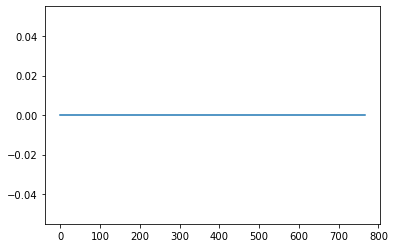

In [18]:
plt.plot(df_y_pred["Arousal"])
plt.show()

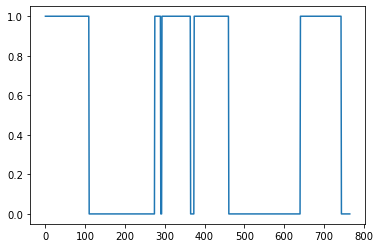

In [19]:
plt.plot(df_y_train["Arousal"])
plt.show()